In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from nltk.corpus import stopwords
import sqlite3
import os
import re
import nltk

In [4]:
from sklearn.metrics import fbeta_score

In [5]:
con =sqlite3.connect('database.sqlite')

In [6]:
dataframe = pd.read_sql_query('''
SELECT * FROM Reviews
WHERE SCORE != 3
''', con)

In [7]:
dataframe.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [8]:
#We do sorting to faciliate data cleaning (removing duplicates)
sorted_df = dataframe.sort_values(by='ProductId', ascending=True)

In [9]:
sorted_df.drop_duplicates(subset={'UserId','ProfileName', 'Time', 'Text'}, keep='first', inplace=True)

### Data Cleaning

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
stop = set(stopwords.words('english'))
stemmer = nltk.stem.SnowballStemmer('english')

In [12]:
def cleanhtml(text):
    cleaninghtml = re.compile('<*?>')
    cleanedhtml = re.sub(cleaninghtml, ' ', text)
    return cleanedhtml

def cleanpunc(text):
    cleaningpunc = re.sub(r'[!|?|&|@|\'|"|#]', r' ', text)
    cleanedpunc = re.sub(r'[.|,|)|(|\|/]', r' ', cleaningpunc)
#     cleanedpunc = re.sub(r'[.|,|;|(|)|/|\]', r' ', cleaningpunc)
    return cleanedpunc

In [13]:
if not os.path.isfile('final.sqlite'):
    final_sent=[]
    for i, sent in enumerate(tqdm(sorted_df['Text'].values)):
        filtered_sent = []
        cleaned = cleanhtml(sent)
        for word in cleaned.split():
            for clean_words in (cleanpunc(word).split()):
                if (clean_words.isalpha()) & (len(clean_words) > 2):
                    if clean_words.lower() not in stop:
                        s = (stemmer.stem(clean_words.lower())).encode('utf-8')
                        filtered_sent.append(s)
                    
        string = b" ".join(filtered_sent)
        final_sent.append(string)
                    
    sorted_df['CleanedText'] = final_sent
    sorted_df['CleanedText']=sorted_df['CleanedText'].str.decode("utf-8")
                    
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    sorted_df.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()  

In [14]:
# Now lets load the final.sqlite to get the CleanedText

In [15]:
conn = sqlite3.connect('final.sqlite')

In [16]:
final_df = pd.read_sql_query('''
SELECT * FROM Reviews
''', conn)

In [17]:
time_sorted_df = final_df.sort_values('Time')

In [18]:
time_sorted_df.shape

(364173, 12)

In [19]:
new_time_sorted_df = time_sorted_df.iloc[0:100000, :]

In [20]:
new_time_sorted_df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,5,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [21]:
time_sorted_score = new_time_sorted_df['Score'].values

In [22]:
time_sorted_df.shape

(364173, 12)

In [23]:
time_sorted_df['Score'] = time_sorted_df['Score'] .apply(lambda x: 1 if x> 3 else 0)

In [24]:
time_sorted_df.Score.value_counts()

1    307063
0     57110
Name: Score, dtype: int64

In [25]:
x_train = time_sorted_df.CleanedText.values[0:60000]
x_cv = time_sorted_df.CleanedText.values[60000:80000]
x_test = time_sorted_df.CleanedText.values[80000:100000]

In [26]:
y_train = time_sorted_df.Score[0:60000]
y_cv = time_sorted_df.Score[60000:80000]
y_test = time_sorted_df.Score[80000:100000]

In [26]:
y_train.value_counts()

1    53147
0     6853
Name: Score, dtype: int64

### Bag of words

In [27]:
count_vect = CountVectorizer(max_features=2000, min_df=5)

In [28]:
bow = count_vect.fit(x_train)

In [29]:
train_bow_count = bow.transform(x_train)

In [30]:
train_bow_count.shape

(60000, 2000)

In [31]:
test_bow_count = bow.transform(x_test)

In [32]:
test_bow_count.shape

(20000, 2000)

In [33]:
cv_bow_count = bow.transform(x_cv)

In [34]:
train_bow_count[0]

<1x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 21 stored elements in Compressed Sparse Row format>

### KNN brute

In [35]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
neighbors = [x for x in range(5,15,2)]
fbetaval=[]
for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=1, algorithm='brute')
    knn.fit(train_bow_count, y_train)
    pred = knn.predict(cv_bow_count)
    fbetaval.append(fbeta_score(y_cv, pred,average='micro', beta=0.5)*100.00)
    print('the fbeta score for k= {} is {}'.format(i, fbetaval[count]))

Text(0,0.5,'fbeta scores')

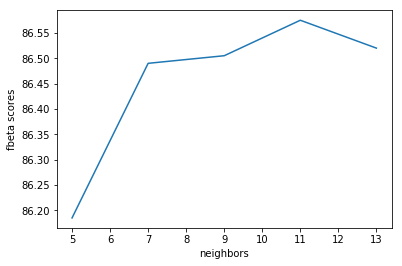

In [37]:
plt.plot(neighbors, fbetaval)
plt.xlabel('neighbors')
plt.ylabel('fbeta scores')

In [38]:
knn = KNeighborsClassifier(11)
knn.fit(train_bow_count, y_train)
pred = knn.predict(test_bow_count)
fbeta = fbeta_score(y_test, pred, average='micro', beta=0.5)*100.00
print('the fbeta score with k=11 on test data is %d%%' %(fbeta))

the fbeta score with k=11 on test data is 87%


In [39]:
train_bow_count

<60000x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 1542762 stored elements in Compressed Sparse Row format>

In [40]:
train_bow_count[0]

<1x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 21 stored elements in Compressed Sparse Row format>

### kd-tree with dense vector

#### truncated svd for dim reduction

In [41]:
from numpy import array
from scipy.sparse import csr_matrix, issparse, isspmatrix, isspmatrix_csr

In [42]:
from sklearn.decomposition import TruncatedSVD

In [49]:
svd = TruncatedSVD(n_components=400, n_iter=5)

In [50]:
svd1 = svd.fit(train_bow_count)

In [51]:
densetrain = svd1.transform(train_bow_count)

In [52]:
densecv = svd1.transform(cv_bow_count)

In [53]:
densetest = svd1.transform(test_bow_count)

In [55]:
densetest

array([[ 1.27910248e+00, -6.35593975e-01,  1.27402083e+00, ...,
        -9.81238364e-02, -1.22491788e-01, -1.88043332e-01],
       [ 3.27074002e-01, -7.29708556e-02, -2.52799098e-01, ...,
        -6.28170665e-02,  8.27292714e-03,  1.57708924e-01],
       [ 1.83392013e+00, -7.41837628e-01, -6.89992687e-01, ...,
         8.63270957e-03, -5.09371720e-02,  1.02596441e-02],
       ...,
       [ 1.33941030e+00, -7.13197432e-01,  5.90565510e-01, ...,
         1.49772839e-01,  7.89736111e-02, -3.07632142e-04],
       [ 2.23146538e+00, -4.76249659e-01, -2.47969884e+00, ...,
         2.90837491e-02,  3.25573497e-02, -8.03919101e-02],
       [ 1.15645259e+00, -6.15326057e-01,  3.46942436e-01, ...,
        -1.57746244e-02, -9.03877920e-02,  4.94201328e-02]])

In [56]:
# issparse(densetest)

In [57]:
fbetascorevals=[]
for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
    knn.fit(densetrain, y_train)
    pred = knn.predict(densecv)
    fbetascorevals.append(fbeta_score(y_cv, pred, average='micro',beta=0.5))
    print('fbetascore for k={} is {}'.format(i, fbetascorevals))

fbetascore for k=5 is [0.86075]
fbetascore for k=7 is [0.86075, 0.8648]
fbetascore for k=9 is [0.86075, 0.8648, 0.86745]
fbetascore for k=11 is [0.86075, 0.8648, 0.86745, 0.8682]
fbetascore for k=13 is [0.86075, 0.8648, 0.86745, 0.8682, 0.8683]


Text(0,0.5,'fbeta scores')

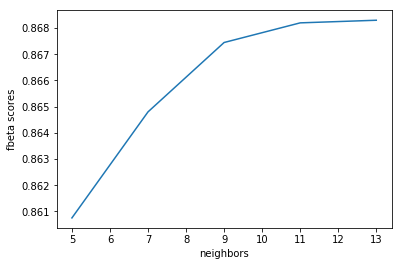

In [58]:
plt.plot(neighbors, fbetascorevals)
plt.xlabel('neighbors')
plt.ylabel('fbeta scores')

In [36]:
knn = KNeighborsClassifier(11)
knn.fit(train_bow_count, y_train)
pred = knn.predict(test_bow_count)
fbeta = fbeta_score(y_test, pred, beta=0.5, average='micro') * float(100)
print('the fbeta with k=11 on test data is %d%%' %(fbeta))

the fbeta with k=11 on test data is 87%


In [37]:
from sklearn import metrics

In [38]:
print(metrics.confusion_matrix(y_test, pred))

[[  114  2560]
 [   37 17289]]


### Metrics

In [39]:
print(metrics.classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.75      0.04      0.08      2674
           1       0.87      1.00      0.93     17326

   micro avg       0.87      0.87      0.87     20000
   macro avg       0.81      0.52      0.51     20000
weighted avg       0.86      0.87      0.82     20000



In [40]:
cmat = (metrics.confusion_matrix(y_test, pred))

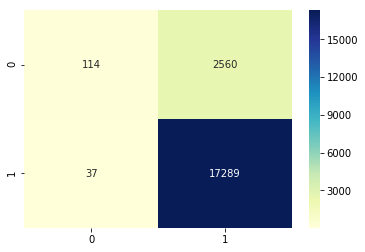

In [41]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

### Precision and recall scores

In [42]:
from sklearn.metrics import precision_score

In [43]:
from sklearn.metrics import recall_score

In [44]:
precision = precision_score(y_test, pred, average='micro')*100.00
recall = recall_score(y_test, pred, average='micro')*100.00

In [45]:
print('the values of precision and recall is %d%% and %d%%' %(precision, recall))

the values of precision and recall is 87% and 87%


precision and recall are same or fp and fn are the same

### F1 scores

In [46]:
from sklearn.metrics import f1_score

In [47]:
f1_score(y_test, pred, average='micro')

0.87015

### tf-idf approach

In [42]:
tfidf = TfidfVectorizer(max_features=2000, max_df=5)

In [43]:
x_train_tfidf = tfidf.fit_transform(x_train)

In [75]:
x_test_tfidf[112]

<1x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [44]:
x_cv_tfidf = tfidf.transform(x_cv)

In [45]:
x_test_tfidf = tfidf.transform(x_test)

### knn brute tfidf

In [52]:
neighbors = [x for x in range(5,15,2)]
fbetascorevals=[]
for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors=i, algorithm='brute')
    knn.fit(x_train_tfidf, y_train)
    pred = knn.predict(x_cv_tfidf)
    fbetascorevals.append(fbeta_score(y_cv, pred, average='micro',beta=0.5))
    print('fbetascore for k={} is {}'.format(i, fbetascorevals))

fbetascore for k=5 is [0.8629]
fbetascore for k=7 is [0.8629, 0.86315]
fbetascore for k=9 is [0.8629, 0.86315, 0.86295]
fbetascore for k=11 is [0.8629, 0.86315, 0.86295, 0.8629]
fbetascore for k=13 is [0.8629, 0.86315, 0.86295, 0.8629, 0.8629]


Text(0,0.5,'fbetascore')

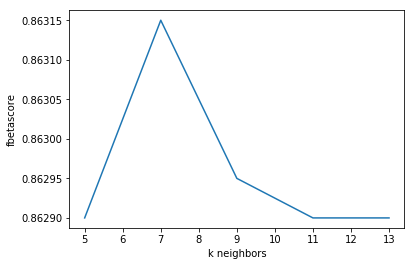

In [53]:
plt.plot(neighbors,fbetascorevals)
plt.xlabel('k neighbors')
plt.ylabel('fbetascore')

In [66]:
knn = KNeighborsClassifier(7)
knn.fit(x_train_tfidf, y_train)
pred = knn.predict(x_test_tfidf)
f1score = f1_score(y_test, pred, average='micro') * 100.0
print('f1 score on test data with k=11 is %d%%' %(f1score))

f1 score on test data with k=11 is 86%


### precision and recall scores

In [67]:
precision = precision_score(y_test, pred, average='micro')*100.00
recall = recall_score(y_test, pred, average='micro')*100.00

In [68]:
print('the values of precision and recall is %d%% and %d%%' %(precision, recall))

the values of precision and recall is 86% and 86%


In [69]:
f1 = f1_score(y_test, pred, average='micro')*100.00

In [70]:
print('f1 score for the above y_test and pred is {}'.format(f1))

f1 score for the above y_test and pred is 86.625


In [71]:
cmat = (metrics.confusion_matrix(y_test, pred))

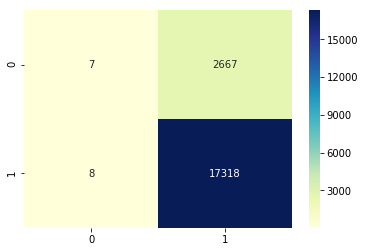

In [72]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

### knn kd-tree tfidf

#### truncated svd for tfidf

In [61]:
from sklearn.decomposition import TruncatedSVD

In [62]:
svd = TruncatedSVD(n_components=500, n_iter=7)

In [63]:
svd1 = svd.fit(x_train_tfidf)

In [74]:
densetrain = svd1.transform(x_train_tfidf)
densecv = svd1.transform(x_cv_tfidf)
densetest = svd1.transform(x_test_tfidf)

In [75]:
neighbors = [x for x in range(5,15,2)]
fbetascorevals=[]
for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
    knn.fit(densetrain, y_train)
    pred = knn.predict(densecv)
    fbetascorevals.append(fbeta_score(y_cv, pred, average='micro',beta=0.5))
    print('fbetascore for k={} is {}'.format(i, fbetascorevals))

fbetascore for k=5 is [0.86215]
fbetascore for k=7 is [0.86215, 0.86275]
fbetascore for k=9 is [0.86215, 0.86275, 0.86275]
fbetascore for k=11 is [0.86215, 0.86275, 0.86275, 0.86295]
fbetascore for k=13 is [0.86215, 0.86275, 0.86275, 0.86295, 0.86295]


Text(0,0.5,'fbetascore')

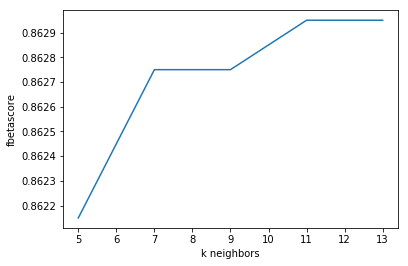

In [83]:
plt.plot(neighbors,fbetascorevals)
plt.xlabel('k neighbors')
plt.ylabel('fbetascore')

In [84]:
knn = KNeighborsClassifier(11)
knn.fit(x_train_tfidf, y_train)
pred = knn.predict(x_test_tfidf)
f1score = f1_score(y_test, pred, average='micro') * 100.0
print('f1 score on test data with k=11 is %d%%' %(f1score))

f1 score on test data with k=11 is 86%


In [85]:
precision = precision_score(y_test, pred, average='micro')*100.00
recall = recall_score(y_test, pred, average='micro')*100.00

In [86]:
print('the values of precision and recall is %d%% and %d%%' %(precision, recall))

the values of precision and recall is 86% and 86%


### F1 scores

In [87]:
f1_score(y_test, pred, average='micro')

0.86625

In [88]:
cmat = (metrics.confusion_matrix(y_test, pred))

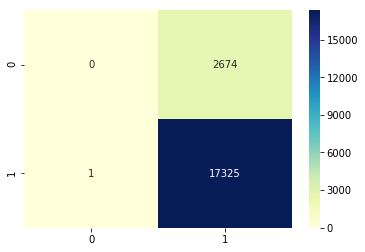

In [89]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

### avgw2v

In [1]:
from gensim.models import Word2Vec

C:\Users\karth\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [27]:
listofsentences = []
for sent in x_train:
    listofsentences.append(sent.split())

In [28]:
training_model = Word2Vec(sentences = listofsentences, min_count=5, workers=4)

In [29]:
model_words = list(training_model.wv.vocab)

In [30]:
from tqdm import tqdm

In [31]:
training = []
for everysentence in tqdm(listofsentences):
    count = 0
    sentence = np.zeros(100)
    for everyword in everysentence:
        if everyword in model_words:
            w2v = training_model.wv[everyword]
            count+=1
            sentence+=w2v
            
    if count !=0:
        sentence/=count
        training.append(sentence)

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [01:09<00:00, 862.44it/s]


In [54]:
test_list = []
for sent in x_test:
    test_list.append(sent.split())

In [124]:
len(test_list)

20000

In [55]:
testing = []
for everysentence in (test_list):
    count = 0
    sentence = np.zeros(100)
    for everyword in everysentence:
        if everyword in model_words:
            w2v = training_model.wv[everyword]
            count+=1
            sentence+=w2v
            
    if count !=0:
        sentence/=count
        testing.append(sentence)

In [57]:
cv_list = []
for sent in x_cv:
    cv_list.append(sent.split())

In [58]:
cv = []
for everysentence in (cv_list):
    count = 0
    sentence = np.zeros(100)
    for everyword in everysentence:
        if everyword in model_words:
            w2v = training_model.wv[everyword]
            count+=1
            sentence+=w2v
            
    if count !=0:
        sentence/=count
        cv.append(sentence)

### avgw2v brute

In [179]:
neighbors = [x for x in range(5,15,2)]
fbetascorevals=[]
for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=1, algorithm='brute')
    knn.fit(training, y_train)
    pred = knn.predict(cv)
    fbetascorevals.append(fbeta_score(y_cv, pred, average='micro',beta=0.5))
    print('fbetascore for k={} is {}'.format(i, fbetascorevals))

fbetascore for k=5 is [0.8803]
fbetascore for k=7 is [0.8803, 0.8803]
fbetascore for k=9 is [0.8803, 0.8803, 0.88025]
fbetascore for k=11 is [0.8803, 0.8803, 0.88025, 0.88105]
fbetascore for k=13 is [0.8803, 0.8803, 0.88025, 0.88105, 0.8812]


Text(0,0.5,'fbetascores')

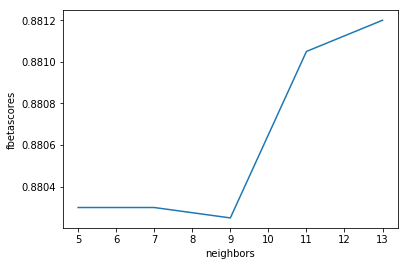

In [180]:
plt.plot(neighbors, fbetascorevals)
plt.xlabel('neighbors')
plt.ylabel('fbetascores')

In [181]:
knn = KNeighborsClassifier(13)
knn.fit(training, y_train)
pred = knn.predict(testing)
f1score = f1_score(y_test, pred, average='micro') * float(100)
print('the f1 for k= 11 is %d%%' %(f1score))

the f1 for k= 11 is 88%


In [183]:
cmat = (metrics.confusion_matrix(y_test, pred))

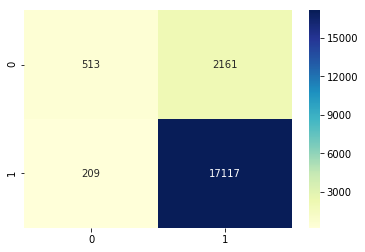

In [184]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

### kd tree

#### truncated svd for dense matrix

In [132]:
svd = TruncatedSVD(n_components=50, n_iter=7)

In [133]:
svd1 = svd.fit(training)
densetrain = svd1.transform(training)
densetest = svd1.transform(testing)
densecv = svd1.transform(cv)

In [134]:
densetrain.shape

(60000, 50)

In [135]:
neighbors = [x for x in range(5,15,2)]
fbetascorevals=[]
for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=1, algorithm='kd_tree')
    knn.fit(densetrain, y_train)
    pred = knn.predict(densecv)
    fbetascorevals.append(fbeta_score(y_cv, pred, average='micro',beta=0.5))
    print('fbetascore for k={} is {}'.format(i, fbetascorevals))

fbetascore for k=5 is [0.8786]
fbetascore for k=7 is [0.8786, 0.88075]
fbetascore for k=9 is [0.8786, 0.88075, 0.8815]
fbetascore for k=11 is [0.8786, 0.88075, 0.8815, 0.88105]
fbetascore for k=13 is [0.8786, 0.88075, 0.8815, 0.88105, 0.8813]


In [ ]:
plt.plot(neighbors, fbetascorevals)
plt.xlabel('neighbors')
plt.ylabel('fbetascores')

In [136]:
knn = KNeighborsClassifier(n_neighbors=11, algorithm='kd_tree')
knn.fit(densetrain, y_train)
pred = knn.predict(densetest)
f1score = f1_score(y_test, pred, average='micro') * float(100)
print('the f1 for k= 11 is %d%%' %(f1score))

the f1 for k= 11 is 88%


### precision and recall

In [142]:
precision = precision_score(y_test, pred, average='micro')*100.00
recall = recall_score(y_test, pred, average='micro')*100.00

In [143]:
print('the values of precision and recall is %d%% and %d%%' %(precision, recall))

the values of precision and recall is 88% and 88%


### F1 scores

In [144]:
f1_score(y_test, pred, average='micro')

0.88085

In [145]:
cmat = (metrics.confusion_matrix(y_test, pred))

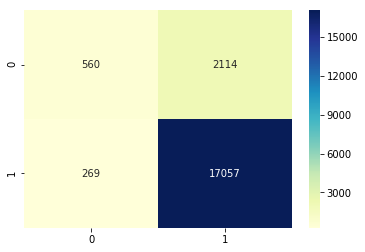

In [146]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

### tf-idf weighted w2v

In [62]:
# training_model.get_latest_training_loss()

In [63]:
tfidfmodel = TfidfVectorizer()
tf_idf_matrix = tfidfmodel.fit_transform(x_train)
tfidf_feat = tfidfmodel.get_feature_names()

In [64]:
dictionary = dict(zip(tfidfmodel.get_feature_names(), list(tfidfmodel.idf_)))

In [65]:
# dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))

In [66]:
weightedtraining = []
row=0
for everysentence in tqdm(listofsentences):
    weighted_sum = 0
    sentence = np.zeros(100)
    for everyword in everysentence:
        if everyword in model_words:
            w2v = training_model.wv[everyword]
            tf_idf = dictionary[everyword]*(everysentence.count(everyword)/len(everysentence))
            sentence += (w2v*tf_idf)
            weighted_sum+=tf_idf
    
    if weighted_sum !=0:
        sentence /= weighted_sum
    weightedtraining.append(sentence)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [01:24<00:00, 708.35it/s]


In [67]:
weightedcv = []
row=0
for everysentence in tqdm(cv_list):
    weighted_sum = 0
    sentence = np.zeros(100)
    for everyword in everysentence:
        if everyword in model_words:
            w2v = training_model.wv[everyword]
            tf_idf = dictionary[everyword]*(everysentence.count(everyword)/len(everysentence))
            sentence += (w2v*tf_idf)
            weighted_sum+=tf_idf
    
    if weighted_sum !=0:
        sentence /= weighted_sum
    weightedcv.append(sentence)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:30<00:00, 652.26it/s]


In [68]:
weightedtest = []
row=0
for everysentence in tqdm(test_list):
    weighted_sum = 0
    sentence = np.zeros(100)
    for everyword in everysentence:
        if everyword in model_words:
            w2v = training_model.wv[everyword]
            tf_idf = dictionary[everyword]*(everysentence.count(everyword)/len(everysentence))
            sentence += (w2v*tf_idf)
            weighted_sum+=tf_idf
    
    if weighted_sum !=0:
        sentence /= weighted_sum
    weightedtest.append(sentence)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:33<00:00, 589.77it/s]


In [155]:
len(weightedtraining)

60000

In [156]:
len(weightedcv)

20000

In [157]:
len(weightedtest)

20000

In [158]:
neighbors = [x for x in range(5,20,2)]
fbetascorevals=[]
for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=1, algorithm='brute')
    knn.fit(weightedtraining, y_train)
    pred = knn.predict(weightedcv)
    fbetascorevals.append(fbeta_score(y_cv, pred, average='micro',beta=0.5))
    print('fbetascore for k={} is {}'.format(i, fbetascorevals))

fbetascore for k=5 is [0.86995]
fbetascore for k=7 is [0.86995, 0.87345]
fbetascore for k=9 is [0.86995, 0.87345, 0.87425]
fbetascore for k=11 is [0.86995, 0.87345, 0.87425, 0.8752]
fbetascore for k=13 is [0.86995, 0.87345, 0.87425, 0.8752, 0.87455]
fbetascore for k=15 is [0.86995, 0.87345, 0.87425, 0.8752, 0.87455, 0.87455]
fbetascore for k=17 is [0.86995, 0.87345, 0.87425, 0.8752, 0.87455, 0.87455, 0.8746]
fbetascore for k=19 is [0.86995, 0.87345, 0.87425, 0.8752, 0.87455, 0.87455, 0.8746, 0.87465]


In [159]:
knn = KNeighborsClassifier(11)
knn.fit(weightedtraining, y_train)
pred = knn.predict(weightedtest)
fscoreval = f1_score(y_test, pred, average='micro') * float(100)
print('the accuracy for k= 11 is %d%%' %(fscoreval))

the accuracy for k= 11 is 87%


Text(0,0.5,'fbetascores')

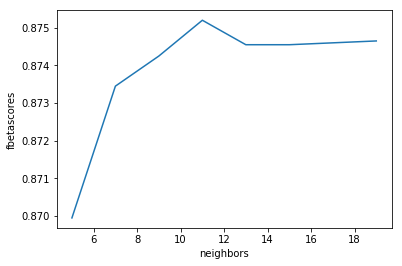

In [160]:
plt.plot(neighbors, fbetascorevals)
plt.xlabel('neighbors')
plt.ylabel('fbetascores')

In [161]:
cmat = (metrics.confusion_matrix(y_test, pred))

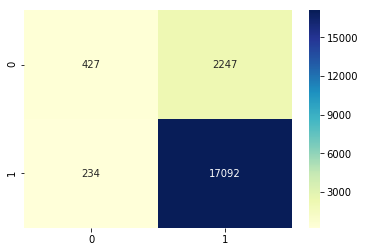

In [162]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

### kd tree

#### truncated svd for dense matrix

In [163]:
svd = TruncatedSVD(n_components=50, n_iter=7)

In [164]:
svd1 = svd.fit(weightedtraining)

In [165]:
densetrain = svd1.transform(weightedtraining)
densecv = svd1.transform(weightedcv)
densetest - svd1.transform(weightedtest)

array([[ 6.48990840e-01,  1.73921962e+00, -2.45594037e+00, ...,
         5.41265675e-02, -3.05077957e-02,  4.77256325e-02],
       [ 3.00193175e-01,  4.27380130e-01, -9.85080979e-01, ...,
         1.64731915e-03, -3.02969516e-01,  5.07079848e-01],
       [ 3.15903121e-01,  1.13674191e+00, -1.21155568e+00, ...,
        -5.10972835e-01, -6.78742276e-02, -3.05048014e-01],
       ...,
       [ 2.42581689e-01,  9.42652386e-01, -1.27542496e+00, ...,
         5.25454924e-02,  1.40579226e-01,  4.98685929e-02],
       [-3.49804631e-01, -3.33664002e+00,  1.94571047e+00, ...,
        -1.21670670e-02,  1.23348583e-01,  9.21722996e-02],
       [ 1.37007146e-01,  2.62713720e+00, -2.40268138e+00, ...,
        -2.99650228e-01, -1.55069856e-01, -1.25725314e-01]])

In [166]:
neighbors = [x for x in range(5,15,2)]
fbetascorevals=[]
for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=1, algorithm='kd_tree')
    knn.fit(densetrain, y_train)
    pred = knn.predict(densecv)
    fbetascorevals.append(fbeta_score(y_cv, pred, average='micro',beta=0.5))
    print('fbetascore for k={} is {}'.format(i, fbetascorevals))

fbetascore for k=5 is [0.8717]
fbetascore for k=7 is [0.8717, 0.87385]
fbetascore for k=9 is [0.8717, 0.87385, 0.87445]
fbetascore for k=11 is [0.8717, 0.87385, 0.87445, 0.8757]
fbetascore for k=13 is [0.8717, 0.87385, 0.87445, 0.8757, 0.8755]


Text(0,0.5,'fbetascores')

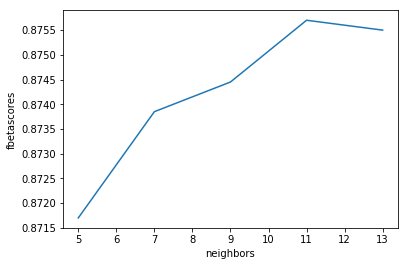

In [167]:
plt.plot(neighbors, fbetascorevals)
plt.xlabel('neighbors')
plt.ylabel('fbetascores')

In [168]:
knn = KNeighborsClassifier(11)
knn.fit(densetrain, y_train)
pred = knn.predict(densetest)
fscoreval = f1_score(y_test, pred, average='micro') * float(100)
print('the accuracy for k= 11 is %d%%' %(fscoreval))

the accuracy for k= 11 is 86%


### precision and recall

In [174]:
precision = precision_score(y_test, pred, average='micro')*100.00
recall = recall_score(y_test, pred, average='micro')*100.00

In [175]:
print('the values of precision and recall is %d%% and %d%%' %(precision, recall))

the values of precision and recall is 86% and 86%


### F1 scores

In [176]:
f1_score(y_test, pred, average='micro')

0.86305

In [177]:
cmat = (metrics.confusion_matrix(y_test, pred))

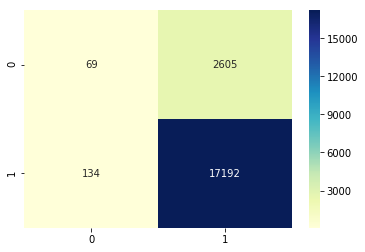

In [178]:
sns.heatmap(data=cmat,annot=True, fmt="d" ,cmap="YlGnBu" )

### OBSERVATIONS:

   VECTORIZER--------------------MODEL-------HYPERPARAMETER------------FBETA/F1_SCORE FOR TRAIN AND TEST

1. BOW------------------------BRUTE-------------11------------------------------------------86/87
2. TFIDF-----------------------BRUTE--------------7-----------------------------------------86/86
3. AVGW2V--------------------BRUTE------------13--------------------------------------------88/88
4. TFIDFW2V------------------BRUTE------------11--------------------------------------------87/87


'''----------------------------------------------------------------------------------------------------------------''''

   VECTORIZER--------------------MODEL-------HYPERPARAMETER------------FBETA/F1_SCORE FOR TRAIN AND TEST

1. BOW-------------------------KDTREE--------------11------------------------------------------86/87
2. TFIDF------------------------KDTREE---------------11------------------------------------------86/86
3. AVGW2V---------------------KDTREE-------------11------------------------------------------88/88
4. TFIDFW2V-------------------KDTREE-------------11------------------------------------------87/86



### pickled for future use:

In [69]:
import pickle
pickle_out = open('tfidfw2v_train.pkl', 'wb')
pickle.dump(weightedtraining, pickle_out)

In [70]:
import pickle
pickle_out = open('tfidfw2v_test.pkl', 'wb')
pickle.dump(weightedtest, pickle_out)

In [71]:
import pickle
pickle_out = open('tfidfw2v_cv.pkl', 'wb')
pickle.dump(weightedcv, pickle_out)

In [59]:
import pickle
pickle_out = open('avgw2v_train.pkl', 'wb')
pickle.dump(training, pickle_out)

In [60]:
import pickle
pickle_out = open('avgw2v_test.pkl', 'wb')
pickle.dump(testing, pickle_out)

In [61]:
import pickle
pickle_out = open('avgw2v_cv.pkl', 'wb')
pickle.dump(cv, pickle_out)

In [48]:
import pickle
pickle_out = open('train_tfidf.pkl', 'wb')
pickle.dump(x_train_tfidf, pickle_out)

In [48]:
import pickle
pickle_out = open('test_tfidf.pkl', 'wb')
pickle.dump(x_test_tfidf, pickle_out)

In [48]:
import pickle
pickle_out = open('cv_tfidf.pkl', 'wb')
pickle.dump(x_cv_tfidf, pickle_out)

In [25]:
import pickle
pickleout = open('train_bow_count.pkl', 'wb')
pickle.dump(train_bow_count, pickleout)

In [25]:
import pickle
pickleout = open('test_bow_count.pkl', 'wb')
pickle.dump(test_bow_count, pickleout)

In [25]:
import pickle
pickleout = open('cv_bow_count.pkl', 'wb')
pickle.dump(cv_bow_count, pickleout)